# 多层感知机的从零开始实现
:label:`sec_mlp_scratch`

我们已经在 :numref:`sec_mlp`中描述了多层感知机（MLP），
现在让我们尝试自己实现一个多层感知机。
为了与之前softmax回归（ :numref:`sec_softmax_scratch` ）
获得的结果进行比较，
我们将继续使用Fashion-MNIST图像分类数据集
（ :numref:`sec_fashion_mnist`）。


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [5]:
help(torch.relu)

Help on built-in function relu in module torch:

relu(...)



## 初始化模型参数

回想一下，Fashion-MNIST中的每个图像由
$28 \times 28 = 784$个灰度像素值组成。
所有图像共分为10个类别。
忽略像素之间的空间结构，
我们可以将每个图像视为具有784个输入特征
和10个类的简单分类数据集。
首先，我们将[**实现一个具有单隐藏层的多层感知机，
它包含256个隐藏单元**]。
注意，我们可以将这两个变量都视为超参数。
通常，我们选择2的若干次幂作为层的宽度。
因为内存在硬件中的分配和寻址方式，这么做往往可以在计算上更高效。

我们用几个张量来表示我们的参数。
注意，对于每一层我们都要记录一个权重矩阵和一个偏置向量。
跟以前一样，我们要为损失关于这些参数的梯度分配内存。


In [3]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

# nn.Parameter 的主要作用是告诉PyTorch这个张量需要被优化
# nn.Parameter(data=None, requires_grad=True)
# torch.randn用于生成服从标准正态分布（均值为0，标准差为1）的随机张量

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [4]:
help(nn.Parameter)

Help on class Parameter in module torch.nn.parameter:

class Parameter(torch.Tensor)
 |  Parameter(data=None, requires_grad=True)
 |  
 |  A kind of Tensor that is to be considered a module parameter.
 |  
 |  Parameters are :class:`~torch.Tensor` subclasses, that have a
 |  very special property when used with :class:`Module` s - when they're
 |  assigned as Module attributes they are automatically added to the list of
 |  its parameters, and will appear e.g. in :meth:`~Module.parameters` iterator.
 |  Assigning a Tensor doesn't have such effect. This is because one might
 |  want to cache some temporary state, like last hidden state of the RNN, in
 |  the model. If there was no such class as :class:`Parameter`, these
 |  temporaries would get registered too.
 |  
 |  Args:
 |      data (Tensor): parameter tensor.
 |      requires_grad (bool, optional): if the parameter requires gradient. Note that
 |          the torch.no_grad() context does NOT affect the default behavior of
 |     

## 激活函数

为了确保我们对模型的细节了如指掌，
我们将[**实现ReLU激活函数**]，
而不是直接调用内置的`relu`函数。


In [5]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## 模型

因为我们忽略了空间结构，
所以我们使用`reshape`将每个二维图像转换为一个长度为`num_inputs`的向量。
只需几行代码就可以(**实现我们的模型**)。


In [6]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

## 损失函数

由于我们已经从零实现过softmax函数（ :numref:`sec_softmax_scratch`），
因此在这里我们直接使用高级API中的内置函数来计算softmax和交叉熵损失。
回想一下我们之前在 :numref:`subsec_softmax-implementation-revisited`中
对这些复杂问题的讨论。
我们鼓励感兴趣的读者查看损失函数的源代码，以加深对实现细节的了解。


In [7]:
loss = nn.CrossEntropyLoss(reduction='none')

## 训练

幸运的是，[**多层感知机的训练过程与softmax回归的训练过程完全相同**]。
可以直接调用`d2l`包的`train_ch3`函数（参见 :numref:`sec_softmax_scratch` ），
将迭代周期数设置为10，并将学习率设置为0.1.


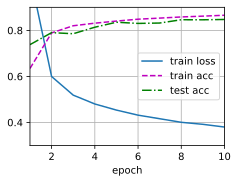

In [8]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

为了对学习到的模型进行评估，我们将[**在一些测试数据上应用这个模型**]。


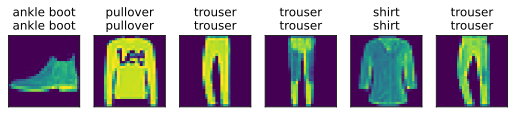

In [9]:
d2l.predict_ch3(net, test_iter)

## 小结

* 手动实现一个简单的多层感知机是很容易的。然而如果有大量的层，从零开始实现多层感知机会变得很麻烦（例如，要命名和记录模型的参数）。

## 练习

1. 在所有其他参数保持不变的情况下，更改超参数`num_hiddens`的值，并查看此超参数的变化对结果有何影响。确定此超参数的最佳值。
1. 尝试添加更多的隐藏层，并查看它对结果有何影响。
1. 改变学习速率会如何影响结果？保持模型架构和其他超参数（包括轮数）不变，学习率设置为多少会带来最好的结果？
1. 通过对所有超参数（学习率、轮数、隐藏层数、每层的隐藏单元数）进行联合优化，可以得到的最佳结果是什么？
1. 描述为什么涉及多个超参数更具挑战性。
1. 如果想要构建多个超参数的搜索方法，请想出一个聪明的策略。


[Discussions](https://discuss.d2l.ai/t/1804)
